# Diabetes Health Indicators — Predictive Analytics and Business Intelligence

This notebook analyzes the Diabetes Health Indicators dataset to identify risk factors and build predictive models. It includes data preprocessing, exploratory data analysis (static and interactive plots), model training (Logistic Regression, Random Forest, XGBoost), and model evaluation (accuracy, confusion matrices, ROC curves). The cleaned dataset is exported in two forms: a numeric ML-ready CSV and a human-readable CSV suitable for Power BI or Tableau.

Note: the analyses and outputs are broadly applicable to healthcare and insurance analytics use cases.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
    print('Warning: XGBoost not available. Install with: pip install xgboost')

In [2]:
csv_path = 'diabetes_binary_health_indicators_BRFSS2015.csv'
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"{csv_path} not found. Upload the Kaggle CSV to the notebook folder or update csv_path.")

df = pd.read_csv(csv_path)
print('Dataset shape:', df.shape)
df.head()

Dataset shape: (253680, 22)


Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0  0.0   9.0        4.0   
1          1.0      3.0       0.0       0.0       0.0  0.0   7.0        6.0   
2          1.0      5.0      30.0      30.0       1.0  0.0   9.0        4.0   
3          0.0      2.0       0.0       0.0       0.0  0.0  11.0        3.0   
4          0.0      2.0       3.0       0.0       0.0  0.0  11.0        5.0   

   Income  
0     3.0  
1     1.0  
2     8.0  
3     6.0  
4     4.0  

[5 rows x 22 columns]

In [3]:
for col in df.columns:
    try:
        if (df[col] % 1 == 0).all():
            df[col] = df[col].astype(int)
    except Exception:
        pass

print('After conversion:')
df.info(verbose=False)
df.head()

After conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Columns: 22 entries, Diabetes_012 to Income
dtypes: int64(22)
memory usage: 42.6 MB


Diabetes_012  HighBP  HighChol  CholCheck  BMI  Smoker  Stroke  \
0             0       1         1          1   40       1       0   
1             0       0         0          0   25       1       0   
2             0       1         1          1   28       0       0   
3             0       1         0          1   27       0       0   
4             0       1         1          1   24       0       0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                     0             0       0  ...              1   
1                     0             1       0  ...              0   
2                     0             0       1  ...              1   
3                     0             1       1  ...              1   
4                     0             1       1  ...              1   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex  Age  Education  \
0            0        5        18        15         1    0    9          4   
1            1        3         0         0         0    0    7          6   
2            1        5        30        30         1    0    9          4   
3            0        2         0         0         0    0   11          3   
4            0        2         3         0         0    0   11          5   

   Income  
0       3  
1       1  
2       8  
3       6  
4       4  

[5 rows x 22 columns]

In [4]:
ml_csv = 'diabetes_ml_ready.csv'
df.to_csv(ml_csv, index=False)
print(f'Exported ML-ready numeric CSV to {ml_csv}')

Exported ML-ready numeric CSV to diabetes_ml_ready.csv


In [5]:
df_viz = df.copy()

binary_map = {0: 'No', 1: 'Yes'}
df_viz['Sex'] = df_viz['Sex'].map({0: 'Female', 1: 'Male'})

binary_columns = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'DiffWalk'
]
for c in binary_columns:
    if c in df_viz.columns:
        df_viz[c] = df_viz[c].map(binary_map)

if 'Diabetes_012' in df_viz.columns:
    df_viz['Diabetes_012'] = df_viz['Diabetes_012'].map({0: 'No Diabetes', 1: 'Prediabetes', 2: 'Diabetes'})

report_dashboard = 'diabetes_dashboard_ready.csv'
df_viz.to_csv(report_dashboard, index=False)
print(f'Exported dashboard-ready CSV to {report_dashboard}')

Exported dashboard-ready CSV to diabetes_dashboard_ready.csv


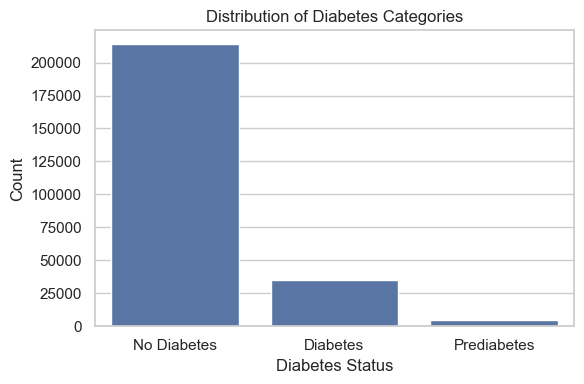

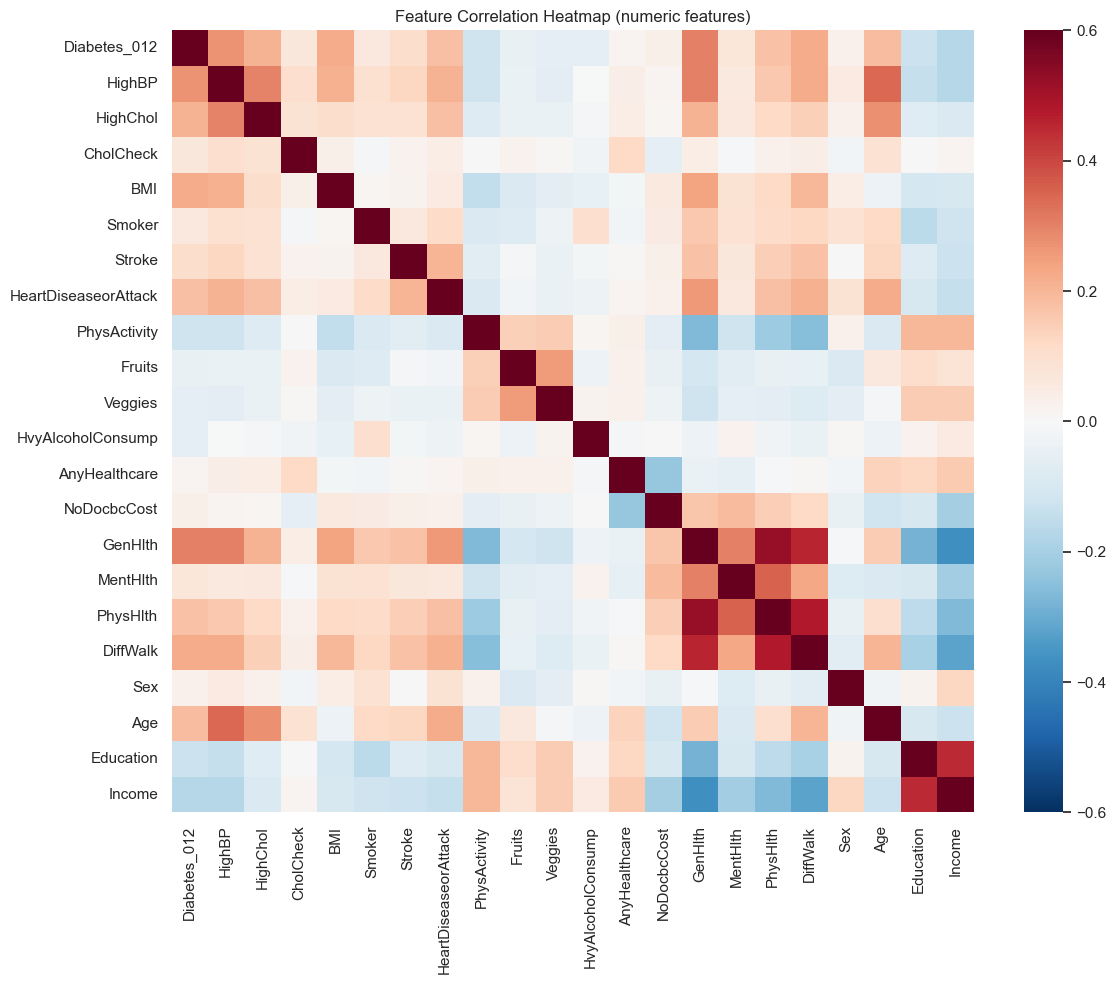

In [6]:
sns.set(style='whitegrid')
plt.figure(figsize=(6,4))
if 'Diabetes_012' in df_viz.columns:
    sns.countplot(x='Diabetes_012', data=df_viz, order=df_viz['Diabetes_012'].value_counts().index)
    plt.title('Distribution of Diabetes Categories')
    plt.xlabel('Diabetes Status')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='RdBu_r', center=0, vmax=0.6, vmin=-0.6)
plt.title('Feature Correlation Heatmap (numeric features)')
plt.tight_layout()
plt.show()

In [7]:
if 'BMI' in df.columns and 'Diabetes_012' in df_viz.columns:
    fig = px.histogram(df, x='BMI', nbins=50, title='BMI Distribution')
    fig.show()

    fig2 = px.histogram(df_viz, x='Sex', color='Diabetes_012', barmode='group', title='Diabetes Status by Sex', text_auto=True)
    fig2.show()

In [8]:
target_col = 'Diabetes_012'
X = df.drop(target_col, axis=1)
y = df[target_col]

if y.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (202944, 21) Test shape: (50736, 21)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
log_model = LogisticRegression(max_iter=1000, multi_class='ovr')
log_model.fit(X_train_scaled, y_train)
log_pred = log_model.predict(X_test_scaled)
print('Logistic Regression accuracy:', accuracy_score(y_test, log_pred))

Logistic Regression accuracy: 0.8456322926521602


In [11]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print('Random Forest accuracy:', accuracy_score(y_test, rf_pred))

Random Forest accuracy: 0.8433262377798801


In [12]:
if XGBClassifier is None:
    print('XGBoost not available in this environment. Skip XGBoost model training.')
else:
    xgb_model = XGBClassifier(eval_metric='mlogloss', objective='multi:softprob', num_class=len(np.unique(y)), random_state=42, use_label_encoder=False)
    xgb_model.fit(X_train, y_train)
    xgb_pred = np.argmax(xgb_model.predict_proba(X_test), axis=1)
    print('XGBoost accuracy:', accuracy_score(y_test, xgb_pred))

XGBoost accuracy: 0.8486873226111636


In [13]:
from sklearn.metrics import classification_report

print('Logistic Regression')
print(classification_report(y_test, log_pred))

print('Random Forest')
print(classification_report(y_test, rf_pred))

if XGBClassifier is not None:
    print('XGBoost')
    print(classification_report(y_test, xgb_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     42741
           1       0.00      0.00      0.00       926
           2       0.52      0.17      0.26      7069

    accuracy                           0.85     50736
   macro avg       0.46      0.38      0.39     50736
weighted avg       0.80      0.85      0.81     50736

Random Forest
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     42741
           1       0.00      0.00      0.00       926
           2       0.50      0.19      0.28      7069

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736

XGBoost
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     42741
           1       0.00      0.00      0.00       926
           2       0.54      0.19

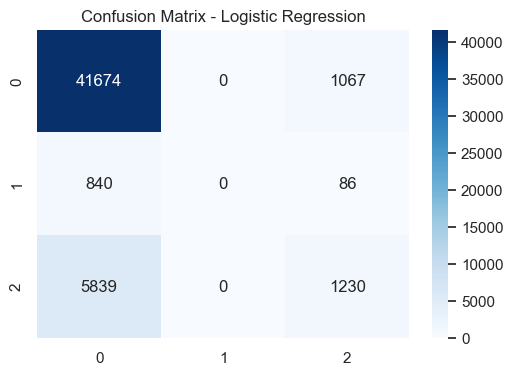

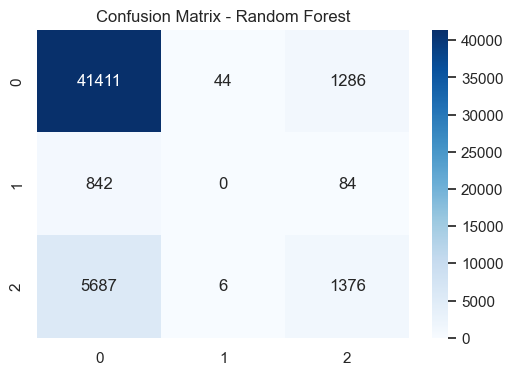

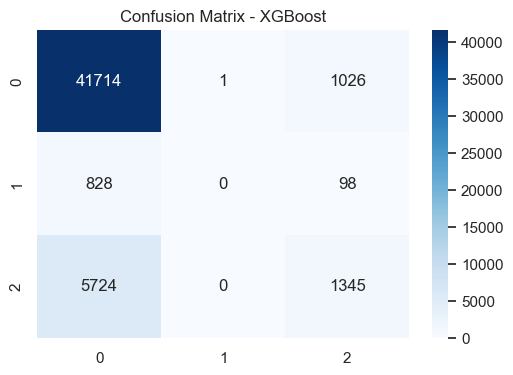

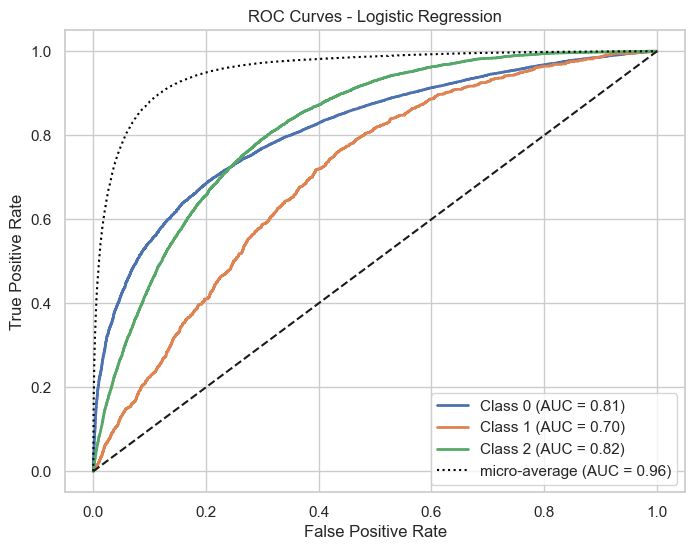

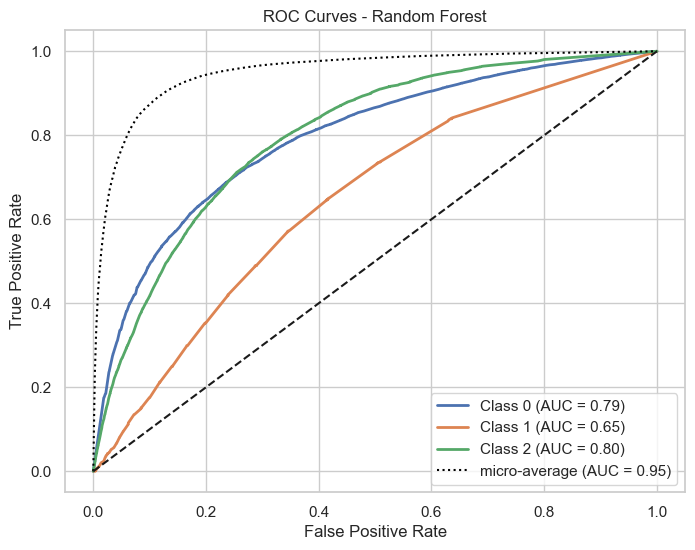

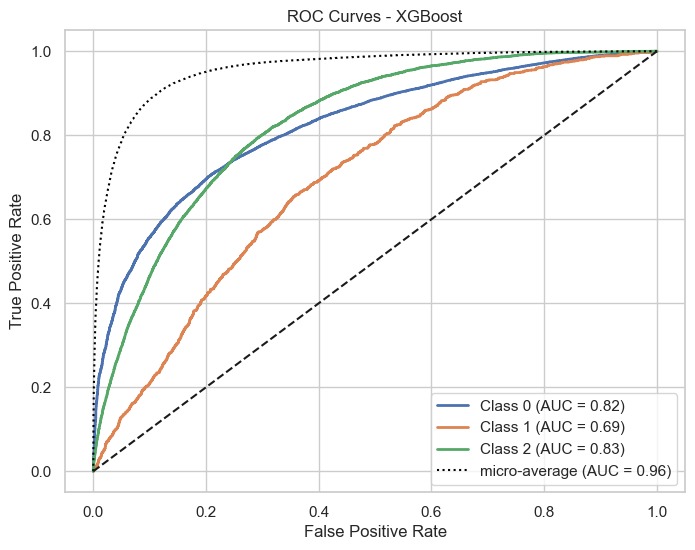

In [14]:
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(y))
labels = sorted(np.unique(y))

# Confusion matrices
cm = confusion_matrix(y_test, log_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

if XGBClassifier is not None:
    cm = confusion_matrix(y_test, xgb_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.show()

# ROC curves (one-vs-rest)
y_test_b = label_binarize(y_test, classes=labels)

# get probability scores if available
try:
    y_score_log = log_model.predict_proba(X_test_scaled)
except Exception:
    y_score_log = None

try:
    y_score_rf = rf_model.predict_proba(X_test)
except Exception:
    y_score_rf = None

if XGBClassifier is not None:
    try:
        y_score_xgb = xgb_model.predict_proba(X_test)
    except Exception:
        y_score_xgb = None
else:
    y_score_xgb = None

from sklearn.metrics import roc_curve, auc

def plot_roc(y_test_b, y_score, model_name):
    if y_score is None:
        print(f'No probability scores for {model_name}; skipping ROC.')
        return
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_b[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {labels[i]} (AUC = {roc_auc:.2f})')
    fpr, tpr, _ = roc_curve(y_test_b.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'micro-average (AUC = {roc_auc:.2f})', linestyle=':', color='black')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

plot_roc(y_test_b, y_score_log, 'Logistic Regression')
plot_roc(y_test_b, y_score_rf, 'Random Forest')
if XGBClassifier is not None:
    plot_roc(y_test_b, y_score_xgb, 'XGBoost')

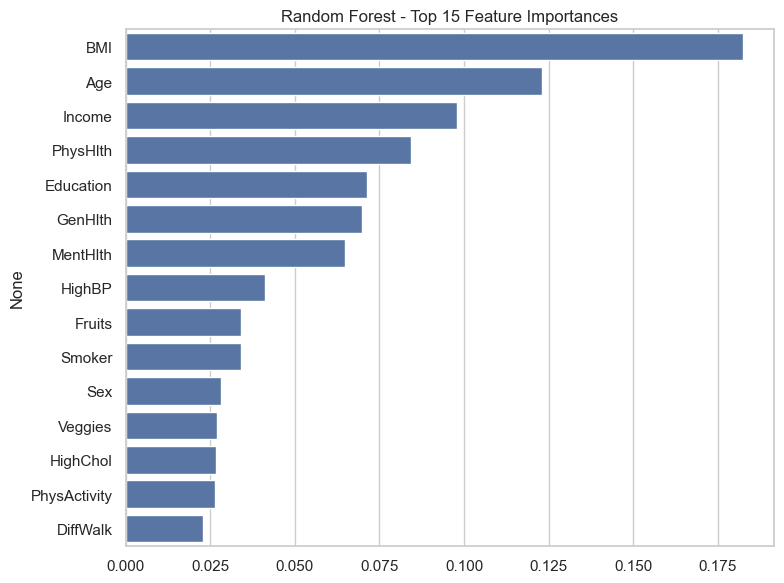

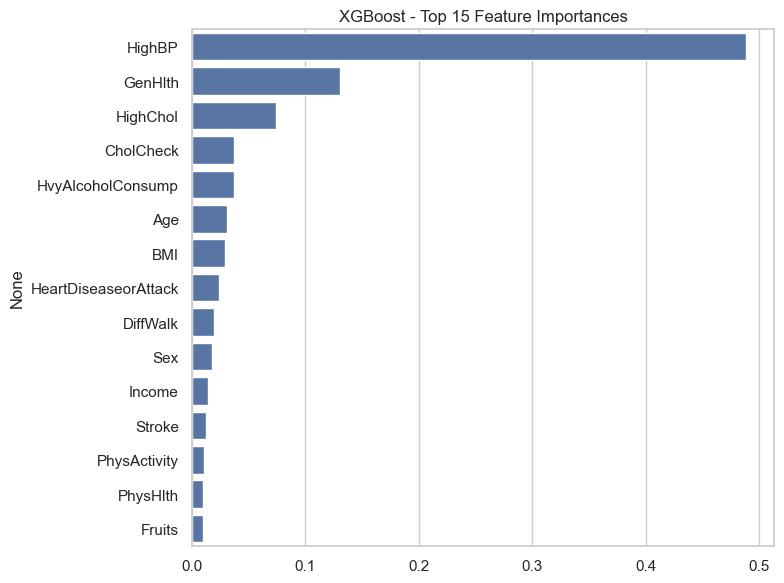

In [15]:
feat_names = X.columns.tolist()
rf_imp = pd.Series(rf_model.feature_importances_, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x=rf_imp.values[:15], y=rf_imp.index[:15])
plt.title('Random Forest - Top 15 Feature Importances')
plt.tight_layout()
plt.show()

if XGBClassifier is not None:
    try:
        xgb_imp = pd.Series(xgb_model.feature_importances_, index=feat_names).sort_values(ascending=False)
        plt.figure(figsize=(8,6))
        sns.barplot(x=xgb_imp.values[:15], y=xgb_imp.index[:15])
        plt.title('XGBoost - Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('Could not plot XGBoost feature importances:', e)

In [16]:
report_df = X_test.copy().reset_index(drop=True)
report_df['true_diabetes'] = y_test.reset_index(drop=True)
report_df['pred_rf'] = rf_pred
if XGBClassifier is not None:
    report_df['pred_xgb'] = xgb_pred

report_df_viz = report_df.copy()
report_df_viz['true_diabetes'] = report_df_viz['true_diabetes'].map({0:'No Diabetes',1:'Prediabetes',2:'Diabetes'})
report_df_viz['pred_rf'] = report_df_viz['pred_rf'].map({0:'No Diabetes',1:'Prediabetes',2:'Diabetes'})
if 'pred_xgb' in report_df_viz.columns:
    report_df_viz['pred_xgb'] = report_df_viz['pred_xgb'].map({0:'No Diabetes',1:'Prediabetes',2:'Diabetes'})

report_csv = 'diabetes_test_with_predictions.csv'
report_df_viz.to_csv(report_csv, index=False)
print(f'Exported test set with predictions to {report_csv}')

Exported test set with predictions to diabetes_test_with_predictions.csv


## Conclusion

This notebook demonstrated a complete workflow for predictive analytics using the Diabetes Health Indicators dataset: data cleaning, exploratory analysis, model training, evaluation, and export. The dashboard-ready CSV (`diabetes_dashboard_ready.csv`) is suitable for Power BI or Tableau. The analysis and methods are applicable to healthcare and insurance analytics contexts.

Next steps: hyperparameter tuning, cross-validation, feature engineering, and explainability (SHAP).